# Media Memorability prediction using HMP,C3D and Captions.

In [0]:
!pip install PyPrind


importing all the libraires needed

# Imporing the libraires

In [0]:
import pandas as pd
from keras import Sequential
from keras import layers
from keras import regularizers
import numpy as np
from keras.layers import Dense,Dropout
from keras.models import Sequential
from string import punctuation
import pyprind
from collections import Counter
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras import preprocessing
import os
import re
import string

# for reproducability
from numpy.random import seed
seed(48)

# Functions for Spearman's constant,HMP,C3D,Caps

In [0]:
def Get_score(Y_pred,Y_true):
    '''Calculate the Spearmann"s correlation coefficient'''
    Y_pred = np.squeeze(Y_pred)
    Y_true = np.squeeze(Y_true)
    if Y_pred.shape != Y_true.shape:
        print('Input shapes don\'t match!')
    else:
        if len(Y_pred.shape) == 1:
            Res = pd.DataFrame({'Y_true':Y_true,'Y_pred':Y_pred})
            score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
            print('The Spearman\'s correlation coefficient is: %.3f' % score_mat.iloc[1][0])
        else:
            for ii in range(Y_pred.shape[1]):
                Get_score(Y_pred[:,ii],Y_true[:,ii])
                
def Get_score_value(Y_pred,Y_true):
    '''Calculate the Spearmann"s correlation coefficient'''
    Y_pred = np.squeeze(Y_pred)
    Y_true = np.squeeze(Y_true)
    if Y_pred.shape != Y_true.shape:
        print('Input shapes don\'t match!')
    else:
        if len(Y_pred.shape) == 1:
            Res = pd.DataFrame({'Y_true':Y_true,'Y_pred':Y_pred})
            score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
            return score_mat.iloc[1][0]
        else:
            return Get_score_value(Y_pred[:,0],Y_true[:,0])
                
                
def read_HMP(fname):
    """Scan HMP(Histogram of Motion Patterns) features from file"""
    with open(fname) as f:
        for line in f:
            pairs=line.split()
            HMP_temp = { int(p.split(':')[0]) : float(p.split(':')[1]) for p in pairs}
    # there are 6075 bins, fill zeros
    HMP = np.zeros(6075)
    for idx in HMP_temp.keys():
        HMP[idx-1] = HMP_temp[idx]            
    return HMP

def read_C3D(fname):
    """Scan vectors from file"""
    with open(fname) as f:
        for line in f:
            C3D =[float(item) for item in line.split()] # convert to float type, using default separator
    return C3D


def read_caps(fname):
    """Load the captions into a dataframe"""
    vn = []
    cap = []
    df = pd.DataFrame();
    with open(fname) as f:
        for line in f:
            pairs = line.split()
            vn.append(pairs[0])
            cap.append(pairs[1])
        df['video']=vn
        df['caption']=cap
    return df



# Loading Ground truth 

In [0]:
# load the ground truth values
labels=pd.read_csv('C:/Users/Reddy/Desktop/ml ass/ground-truth.csv')
labels.head()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,video3.webm,0.924,34,0.846,13
1,video4.webm,0.923,33,0.667,12
2,video6.webm,0.863,33,0.700,10
3,video8.webm,0.922,33,0.818,11
4,video10.webm,0.950,34,0.900,10


In [0]:
labels.dtypes

video                         object
short-term_memorability      float64
nb_short-term_annotations      int64
long-term_memorability       float64
nb_long-term_annotations       int64
dtype: object

In [0]:
vid = labels.video.values
len(vid)

6000

# HMP feature Training

In [0]:

os.chdir('C:/Users/Reddy/Desktop/ml ass/devset/')
features_hmp = pd.DataFrame({'video': vid, 'HMP': [read_HMP('./HMP'+'/'+os.path.splitext(item)[0]+'.txt') for item in vid]})
features_hmp.head()

,video,HMP
0,video3.webm,"[0.125563, 0.024036, 0.000314, 0.0, 0.015864, ..."
1,video4.webm,"[0.007526, 0.001421, 6.8e-05, 0.0, 0.001184, 0..."
2,video6.webm,"[0.109584, 0.018978, 0.000289, 0.0, 0.008774, ..."
3,video8.webm,"[0.120431, 0.013561, 0.000277, 0.0, 0.018974, ..."
4,video10.webm,"[0.005026, 0.001356, 5.5e-05, 0.0, 0.000665, 2..."


In [0]:
# os.chdir('C:/Users/Reddy/Desktop/ml ass/testset/')
tevid = os.listdir('C:/Users/Reddy/Desktop/ml ass/testset/HMP_test')
features_hmp_test = pd.DataFrame({'video': tevid,'HMP': [read_HMP('./HMP_test'+'/'+item) for item in tevid],
                       })

In [0]:
from sklearn import preprocessing


In [0]:
features_hmp_test.head()

,video,HMP
0,video10000.txt,"[0.127454, 0.020965, 0.000221, 0.0, 0.009964, ..."
1,video10001.txt,"[0.015911, 0.003141, 0.000124, 0.0, 0.001083, ..."
2,video10002.txt,"[0.041081, 0.013914, 0.000198, 0.0, 0.002648, ..."
3,video10003.txt,"[0.047053, 0.009497, 0.000137, 0.0, 0.00867, 9..."
4,video10004.txt,"[0.003161, 0.00033, 0.0, 0.0, 0.000189, 0.0, 0..."


In [0]:
X_test = np.stack(features_hmp_test['HMP'].values)


Stacking of training hmp values to convert coloumns to index and normalizing them normalize function and 

splitting the train dataset into train and validation set by train_test_split from sklearn package.

In [0]:
X = np.stack(features_hmp['HMP'].values)
Xnor = preprocessing.normalize(X)
Y = labels[['short-term_memorability','long-term_memorability']].values

#Y = Y[:,1]
X_train, X_val, Y_train, Y_val = train_test_split(Xnor,Y, test_size=0.2, random_state=42)

visulaizing the train and validation sets.

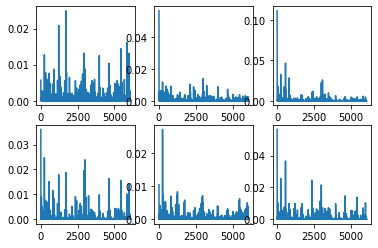

In [0]:

nrows,ncols = 2,3
N = nrows*ncols
ind = np.random.choice(6000,size=N)
for ii in range(N):
    plt.subplot(nrows,ncols,ii+1)
    plt.plot(X[ind[ii],:])
plt.show()

## Creating 5 layer neural network 

In [0]:
model_hmp = Sequential()
model_hmp.add(Dense(400,activation='relu', kernel_regularizer=None,input_shape=(X_train.shape[1],)))
model_hmp.add(Dropout(0.50))
model_hmp.add(Dense(400,activation='relu', kernel_regularizer=None))
model_hmp.add(Dropout(0.50))
model_hmp.add(Dense(400,activation='relu', kernel_regularizer=None))
model_hmp.add(Dropout(0.50))
model_hmp.add(Dense(50,activation='relu',kernel_regularizer=None))
model_hmp.add(Dropout(0.25))
model_hmp.add(Dense(2,activation='sigmoid'))
model_hmp.summary()
model_hmp.compile(optimizer='rmsprop',loss=['mae'],metrics=['acc'])
history=model_hmp.fit(x=X_train,y=Y_train, batch_size=60, epochs=40, validation_data=(X_val,Y_val), shuffle=True, verbose=True)

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_107 (Dense)            (None, 400)               2430400   
_________________________________________________________________
dropout_85 (Dropout)         (None, 400)               0         
_________________________________________________________________
dense_108 (Dense)            (None, 400)               160400    
_________________________________________________________________
dropout_86 (Dropout)         (None, 400)               0         
_________________________________________________________________
dense_109 (Dense)            (None, 400)               160400    
_________________________________________________________________
dropout_87 (Dropout)         (None, 400)               0         
_________________________________________________________________
dense_110 (Dense)            (None, 50)              

## Visualizing the training and validation loss

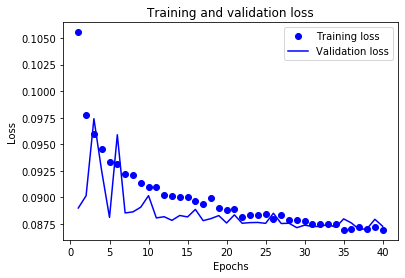

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.figure()
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Predicitng the validation set rank and visulaing the short and long term scores.

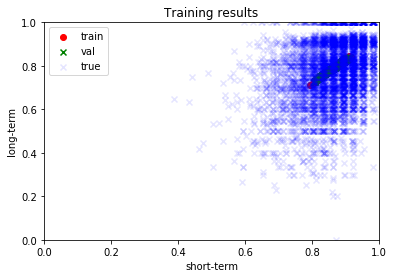

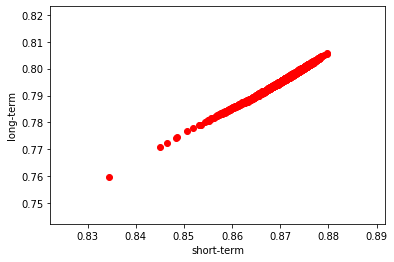

In [0]:
Y_pred_train = model_hmp.predict(X_train)
Y_pred_val = model_hmp.predict(X_val)

if len(Y.shape) == 2:
    plt.figure()
    plt.scatter(Y_pred_train[:,0],Y_pred_train[:,1],marker='o',c='r',label='train')
    plt.scatter(Y_pred_val[:,0],Y_pred_val[:,1],marker='x',c='g',label='val')
    plt.scatter(Y[:,0],Y[:,1],marker='x',c='b',label='true',alpha=0.1)
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.legend()
    plt.xlabel('short-term')
    plt.ylabel('long-term')
    plt.title('Training results')
    plt.show()
    
    # plot testing results
    Y_pred = model_hmp.predict(X_test[:,:],batch_size=32)
    plt.figure()
    plt.scatter(Y_pred[:,0],Y_pred[:,1],marker='o',c='r')
    plt.xlabel('short-term')
    plt.ylabel('long-term')
    plt.show()
    
else:
    plt.figure()
    plt.scatter(Y_pred_train,Y_train,marker='o',c='r',label='train')
    plt.scatter(Y_pred_val,Y_val,marker='x',c='g',label='val')
    #plt.scatter(Y[:,0],Y[:,1],marker='x',c='b',label='true',alpha=0.1)
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.legend()
    plt.xlabel('true')
    plt.ylabel('pred')
    plt.title('Training results [short-term]')
    plt.show()


In [0]:
Get_score(Y_pred_val,Y_val)
hmp_prediction = Y_pred_val


The Spearman's correlation coefficient is: 0.325
The Spearman's correlation coefficient is: 0.145


In [0]:
# model_hmp.save('./hmp.h5')

# Caption feature training 

In [0]:
cap_path = 'C:/Users/Reddy/Desktop/ml ass/devset/dev-set_video-captions.txt'
df_captions=read_caps(cap_path)
df_captions.head()

,video,caption
0,video3.webm,blonde-woman-is-massaged-tilt-down
1,video4.webm,roulette-table-spinning-with-ball-in-closeup-shot
2,video6.webm,khr-gangsters
3,video8.webm,medical-helicopter-hovers-at-airport
4,video10.webm,couple-relaxing-on-picnic-crane-shot


In [0]:
# load the captions - test set
cap_path = 'C:/Users/Reddy/Desktop/ml ass/testset/test-set-1_video-captions.txt'
df_captions_test=read_caps(cap_path)
df_captions_test.head()

,video,caption
0,video7494.webm,green-jeep-struggling-to-drive-over-huge-rocks
1,video7495.webm,hiking-woman-tourist-is-walking-forward-in-mou...
2,video7496.webm,close-up-of-african-american-doctors-hands-usi...
3,video7497.webm,slow-motion-of-a-man-using-treadmill-in-the-gy...
4,video7498.webm,slow-motion-of-photographer-in-national-park


## Pre Processing

Dropping the useless coloumns like nb_short-term_annotations and nb_long-term_annotations

In [0]:
labels_cap_train = labels.drop(['nb_short-term_annotations', 'nb_long-term_annotations'], axis=1)

In [0]:
labels_cap_train.head()

,video,short-term_memorability,long-term_memorability
0,video3.webm,0.924,0.846
1,video4.webm,0.923,0.667
2,video6.webm,0.863,0.700
3,video8.webm,0.922,0.818
4,video10.webm,0.950,0.900


Concating the test and train set into a single set.

In [0]:
df_cap = pd.concat([df_captions, df_captions_test],ignore_index=True)


In [0]:
df_cap.head()

,video,caption
0,video3.webm,blonde-woman-is-massaged-tilt-down
1,video4.webm,roulette-table-spinning-with-ball-in-closeup-shot
2,video6.webm,khr-gangsters
3,video8.webm,medical-helicopter-hovers-at-airport
4,video10.webm,couple-relaxing-on-picnic-crane-shot


In [0]:
df_cap.tail()

,video,caption
7995,video10004.webm,astronaut-in-outer-space-against-the-backdrop-...
7996,video10005.webm,young-women-lying-on-sunbed-and-applying-sun-c...
7997,video10006.webm,doctor-talking-to-patient-using-a-tablet-to-ex...
7998,video10007.webm,businessman-sitting-on-the-beach-on-inflatable...
7999,video10008.webm,woman-eating-ice-cream-and-sitting-in-the-stre...


In [0]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

function to remove punctuation

In [0]:

def remove_punct(text):
  text_nopunct="".join([char for char in text if char not in string.punctuation])  #it will discard all punctuation
  return text_nopunct

Removal of punctuations between the words

In [0]:
df_cap['cleaned body']=df_cap['caption'].apply(lambda x: remove_punct(x))
df_cap.tail()

,video,caption,cleaned body
7995,video10004.webm,astronaut-in-outer-space-against-the-backdrop-...,astronautinouterspaceagainstthebackdropofthepl...
7996,video10005.webm,young-women-lying-on-sunbed-and-applying-sun-c...,youngwomenlyingonsunbedandapplyingsuncream
7997,video10006.webm,doctor-talking-to-patient-using-a-tablet-to-ex...,doctortalkingtopatientusingatablettoexplainher...
7998,video10007.webm,businessman-sitting-on-the-beach-on-inflatable...,businessmansittingonthebeachoninflatablemattre...
7999,video10008.webm,woman-eating-ice-cream-and-sitting-in-the-stre...,womaneatingicecreamandsittinginthestreetcafe


Tokenization

In [0]:
import re

#function to tokenise

def tokenize(text):
  tokens=re.split('\W+',text)
  return tokens
df_cap['tokenized_body']=df_cap['caption'].apply(lambda x: tokenize(x.lower()))
df_cap.tail()

,video,caption,cleaned body,tokenized_body
7995,video10004.webm,astronaut-in-outer-space-against-the-backdrop-...,astronautinouterspaceagainstthebackdropofthepl...,"[astronaut, in, outer, space, against, the, ba..."
7996,video10005.webm,young-women-lying-on-sunbed-and-applying-sun-c...,youngwomenlyingonsunbedandapplyingsuncream,"[young, women, lying, on, sunbed, and, applyin..."
7997,video10006.webm,doctor-talking-to-patient-using-a-tablet-to-ex...,doctortalkingtopatientusingatablettoexplainher...,"[doctor, talking, to, patient, using, a, table..."
7998,video10007.webm,businessman-sitting-on-the-beach-on-inflatable...,businessmansittingonthebeachoninflatablemattre...,"[businessman, sitting, on, the, beach, on, inf..."
7999,video10008.webm,woman-eating-ice-cream-and-sitting-in-the-stre...,womaneatingicecreamandsittinginthestreetcafe,"[woman, eating, ice, cream, and, sitting, in, ..."


Count vectorizer converts a collection of text into a matrix of token counts.

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect=CountVectorizer(min_df=1, stop_words='english')

In [0]:
X_counts=count_vect.fit_transform(df_cap['caption'])
print(X_counts.shape)

(8000, 5691)


In [0]:
X_counts_seq=X_counts.toarray()


In [0]:
X_counts_seq.shape

(8000, 5691)

Converting the whole captions df into 80% train and 20% test.

In [0]:
X_train = X_counts_seq[0:6000]
X_test = X_counts_seq[6000:]

In [0]:
print('X_train', X_train.shape)
print('X_test', X_test.shape)

X_train (6000, 5691)
X_test (2000, 5691)


In [0]:
Y=labels_cap_train[['short-term_memorability','long-term_memorability']].values  #targets
X=X_train #input

In [0]:
X.shape

(6000, 5691)

Splitting the train data into train and validation sets.

In [0]:
X_train, X_val, Y_train, Y_val = train_test_split(X,Y, test_size=0.2, random_state=42)


In [0]:
print('X_train', X_train.shape)
print('X_val', X_val.shape)
print('Y_train', Y_train.shape)
print('Y_val', Y_val.shape)

X_train (4800, 5691)
X_val (1200, 5691)
Y_train (4800, 2)
Y_val (1200, 2)


In [0]:
n_cols = X_train.shape[1]
n_cols

5691

## A feed forward network with 6 layers with adam optimizer

Loss function: mean_squared_error
Train on 4800 samples, validate on 1200 samples
Epoch 1/20
4800/4800 [==============================] - 11s 2ms/sample - loss: 0.1401 - accuracy: 0.5427 - val_loss: 0.0141 - val_accuracy: 0.7100
Epoch 2/20
4800/4800 [==============================] - 8s 2ms/sample - loss: 0.0279 - accuracy: 0.6060 - val_loss: 0.0142 - val_accuracy: 0.7100
Epoch 3/20
4800/4800 [==============================] - 8s 2ms/sample - loss: 0.0244 - accuracy: 0.6402 - val_loss: 0.0151 - val_accuracy: 0.7100
Epoch 4/20
4800/4800 [==============================] - 8s 2ms/sample - loss: 0.0234 - accuracy: 0.6473 - val_loss: 0.0164 - val_accuracy: 0.7100
Epoch 5/20
4800/4800 [==============================] - 8s 2ms/sample - loss: 0.0225 - accuracy: 0.6581 - val_loss: 0.0147 - val_accuracy: 0.7100
Epoch 6/20
4800/4800 [==============================] - 7s 2ms/sample - loss: 0.0213 - accuracy: 0.6596 - val_loss: 0.0156 - val_accuracy: 0.7100
Epoch 7/20
4800/4800 [===================

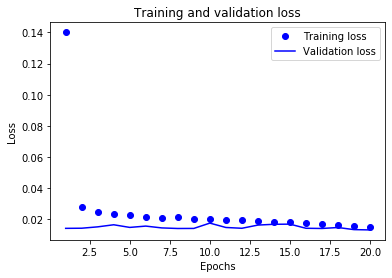

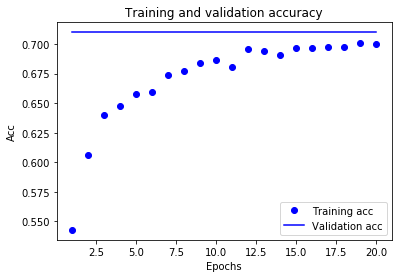

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout


model_cap = Sequential()

model_cap.add(Dense(700, activation='sigmoid', kernel_regularizer=regularizers.l1(0.),input_shape=(n_cols,)))
model_cap.add(Dropout(0.5)) 
model_cap.add(Dense(700, activation='sigmoid',kernel_regularizer=regularizers.l1(0.)))
model_cap.add(Dropout(0.4))
model_cap.add(Dense(650, activation='sigmoid',kernel_regularizer=regularizers.l1(0.)))
model_cap.add(Dropout(0.4))
model_cap.add(Dense(650, activation='sigmoid',kernel_regularizer=regularizers.l1(0.)))
model_cap.add(Dropout(0.3))
model_cap.add(Dense(150, activation='sigmoid',kernel_regularizer=regularizers.l1(0.)))
model_cap.add(Dropout(0.3)) 
model_cap.add(Dense(2))



# Compiling the model
model_cap.compile(optimizer='adam', loss = 'mean_squared_error',metrics=['accuracy'])


# Verifying that model contains information from compiling
print("Loss function: " + model_cap.loss)

# Fitting the model
history = model_cap.fit(X_train,Y_train,epochs=20,validation_data=(X_val,Y_val), shuffle=True, verbose=True)
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

## Predicting the rank based on validation set.

In [0]:
predictions = model_cap.predict(X_val)
# print(predictions)
Get_score(predictions, Y_val)
cap_pred=predictions

The Spearman's correlation coefficient is: 0.443
The Spearman's correlation coefficient is: 0.207


In [0]:
# model_cap.save('./cap.h5')

In [0]:
labels_test = labels_test.drop(['nb_short-term_annotations', 'nb_long-term_annotations'], axis=1)

In [0]:
labels_test.head()

,video,short-term_memorability,long-term_memorability
0,7494,NaN,NaN
1,7495,NaN,NaN
2,7496,NaN,NaN
3,7497,NaN,NaN
4,7498,NaN,NaN


# Captions with Embedding
    

## preprocessing 

Tokenization of original text.

In [0]:
res_len=np.zeros(len(df_captions))
for ii in range(len(df_captions)):
    text = df_captions.caption[ii]
    res_len[ii]=len(text.split())

In [0]:
maxlen = int(max(res_len))


Padding of the tokens to make everything in same length

In [0]:
from collections import Counter
counts=Counter()
from keras.preprocessing.sequence import pad_sequences
# build the word index
len_token = len(counts)
tokenizer = Tokenizer(num_words=len_token)
tokenizer.fit_on_texts(list(df_captions.caption.values))
sequences = tokenizer.texts_to_sequences(list(df_captions.caption.values))

maxlen = 20
X_seq = pad_sequences(sequences,maxlen=maxlen)

In [0]:
Y = labels[['short-term_memorability','long-term_memorability']].values
X = X_seq
X_all = X

Splitting of captions into train and valdiation sets.

In [0]:
X_train, X_val, Y_train, Y_val = train_test_split(X,Y, test_size=0.2, random_state=42)


## Neural network model with visualization of loss and accuracy

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 20, 8)             41536     
_________________________________________________________________
flatten_8 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 500)               80500     
_________________________________________________________________
dropout_37 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_38 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 500)              

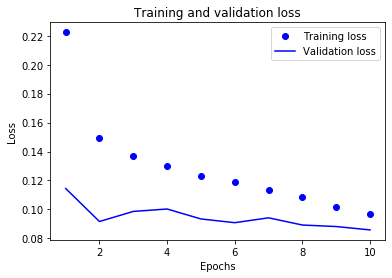

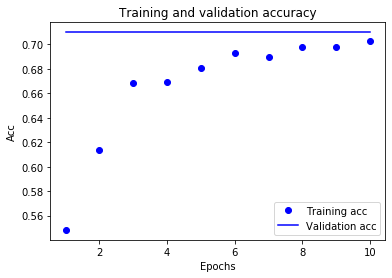

In [0]:
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.layers import Embedding


model_embedding = Sequential()
model_embedding.add(Embedding(1+X_all.max(),8,input_length=maxlen))
model_embedding.add(Flatten())
model_embedding.add(Dense(500,activation='sigmoid',kernel_regularizer=None))
model_embedding.add(Dropout(0.5))
model_embedding.add(Dense(500,activation='sigmoid',kernel_regularizer=None))
model_embedding.add(Dropout(0.5))
model_embedding.add(Dense(500,activation='sigmoid',kernel_regularizer=None))
model_embedding.add(Dropout(0.5))
model_embedding.add(Dense(100,activation='sigmoid',kernel_regularizer=None))
model_embedding.add(Dropout(0.5))
model_embedding.add(Dense(2))

model_embedding.compile(optimizer='adam',loss='mae',metrics=['acc'])
model_embedding.summary()
history = model_embedding.fit(X_train,Y_train,epochs=10,batch_size=32,validation_data=(X_val,Y_val))

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [0]:
Yvector_pred = model_embedding.predict(X_val)
Get_score(Yvector_pred, Y_val)


The Spearman's correlation coefficient is: 0.412
The Spearman's correlation coefficient is: 0.204


In [0]:
# model_embedding.save('./embedding.h5')

In [0]:
embedding_prediction = Yvector_pred


# C3D feature training

In [0]:
# os.chdir('C:/Users/Reddy/Desktop/ml ass/testset/')
c3df = os.listdir('C:/Users/Reddy/Desktop/ml ass/devset/')
features_c3d = pd.DataFrame({'video': vid,
                   'C3D': [read_C3D('./C3D/'+os.path.splitext(item)[0]+'.txt') for item in vid],
                       })

In [0]:
features_c3d.head()

,video,C3D
0,video3.webm,"[0.02024942, 0.0015778, 0.00082625, 0.00094509..."
1,video4.webm,"[0.000118, 0.00089075, 0.00018769, 4.543e-05, ..."
2,video6.webm,"[0.01176522, 0.00074577, 0.00078353, 1.328e-05..."
3,video8.webm,"[0.00022343, 0.00016499, 7.35e-06, 1.615e-05, ..."
4,video10.webm,"[9.006e-05, 0.00061494, 0.00343634, 0.00128092..."


In [0]:
X = np.stack(features_c3d['C3D'].values)
Y = labels[['short-term_memorability','long-term_memorability']].values

In [0]:
print(X.shape)
print(Y.shape)

(6000, 101)
(6000, 2)


 ## Model with alternating relu and signmoid activation fuctions and sigmoid layer in output to restric the values between[0,1]

In [0]:
X_train, X_val, Y_train, Y_val = train_test_split(X,Y, test_size=0.2, random_state=42)
modelc3d = Sequential()
modelc3d.add(Dense(500,activation='relu', kernel_regularizer=None,input_shape=(X.shape[1],)))
modelc3d.add(Dropout(0.40))
modelc3d.add(Dense(500,activation='sigmoid', kernel_regularizer=None))
modelc3d.add(Dropout(0.40))
modelc3d.add(Dense(500,activation='relu', kernel_regularizer=None))
modelc3d.add(Dropout(0.40))
modelc3d.add(Dense(60,activation='sigmoid',kernel_regularizer=None))
modelc3d.add(Dropout(0.25))
modelc3d.add(Dense(2))
modelc3d.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_66 (Dense)             (None, 500)               51000     
_________________________________________________________________
dropout_53 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_67 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_54 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_68 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_55 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_69 (Dense)             (None, 60)              

Compiling the model with adam and mean square error as optimizer and loss metric. we can see that there is no overfitting of the data.

In [0]:
modelc3d.compile(optimizer='adam',loss=['mse'],metrics=['acc'])
history_c3d=modelc3d.fit(x=X_train,y=Y_train,epochs=26,validation_data=(X_val,Y_val),shuffle=True,verbose=True)

Train on 4800 samples, validate on 1200 samples
Epoch 1/26
4800/4800 [==============================] - 3s 603us/sample - loss: 0.0701 - acc: 0.5638 - val_loss: 0.0191 - val_acc: 0.7100
Epoch 2/26
4800/4800 [==============================] - 2s 349us/sample - loss: 0.0324 - acc: 0.6142 - val_loss: 0.0139 - val_acc: 0.7100
Epoch 3/26
4800/4800 [==============================] - 2s 381us/sample - loss: 0.0294 - acc: 0.6342 - val_loss: 0.0138 - val_acc: 0.7100
Epoch 4/26
4800/4800 [==============================] - 2s 337us/sample - loss: 0.0268 - acc: 0.6592 - val_loss: 0.0169 - val_acc: 0.7100
Epoch 5/26
4800/4800 [==============================] - 2s 418us/sample - loss: 0.0247 - acc: 0.6650 - val_loss: 0.0159 - val_acc: 0.7100
Epoch 6/26
4800/4800 [==============================] - 2s 363us/sample - loss: 0.0229 - acc: 0.6823 - val_loss: 0.0142 - val_acc: 0.7100
Epoch 7/26
4800/4800 [==============================] - 2s 348us/sample - loss: 0.0218 - acc: 0.6885 - val_loss: 0.0149 - va

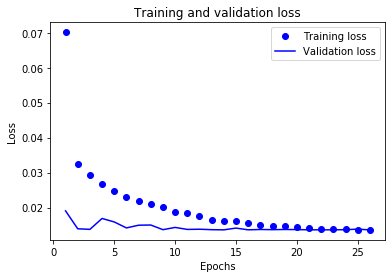

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [0]:
loss = history_c3d.history['loss']
val_loss = history_c3d.history['val_loss']

epochs = range(1,len(loss)+1)

plt.figure()
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()

In [0]:
Y_pred = modelc3d.predict(X_val)


In [0]:
Get_score(Y_pred,Y_val)


The Spearman's correlation coefficient is: 0.275
The Spearman's correlation coefficient is: 0.124


In [0]:
pwd

'C:\\Users\\Reddy\\Desktop\\ml ass\\devset'

In [0]:
c3d_prediction = Y_pred
# modelc3d.save('./c3d.h5')

In [0]:
ensemble=(c3d_prediction+embedding_prediction+cap_pred+hmp_prediction)/4

In [0]:
Get_score(ensemble,Y_val)


The Spearman's correlation coefficient is: 0.457
The Spearman's correlation coefficient is: 0.221


#Predictions on test set

loading ground truth test

In [0]:
labels_test=pd.read_csv('C:/Users/Reddy/Desktop/ml ass/testset/ground_truth_template.csv')
labels_test.head()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,7494,NaN,33,NaN,12
1,7495,NaN,34,NaN,10
2,7496,NaN,32,NaN,13
3,7497,NaN,33,NaN,10
4,7498,NaN,33,NaN,10


In [0]:
vid = labels_test.video.values
len(vid)

2000

##C3D Prediction

In [0]:
os.chdir('C:/Users/Reddy/Desktop/ml ass/testset/')
c3d_test = pd.DataFrame({'video': vid,
                   'C3D': [read_C3D('./C3D_test/video'+str(item)+'.txt') for item in vid],
                       })

In [0]:
c3d_test.head()

,video,C3D
0,7494,"[0.00013576, 0.0002133, 0.00124759, 1.149e-05,..."
1,7495,"[0.00012659, 2.377e-05, 0.04950115, 2.418e-05,..."
2,7496,"[0.48898152, 0.00058536, 2.454e-05, 0.00016031..."
3,7497,"[0.24925078, 0.00101763, 8.02e-06, 1.92e-05, 2..."
4,7498,"[0.00989415, 3.413e-05, 0.00261261, 2.1e-06, 1..."


predicting 

In [0]:
X_testc3d = np.stack(c3d_test['C3D'].values)

In [0]:
c3d_test_prediction = modelc3d.predict(X_testc3d)

In [0]:
c3d_test_prediction

array([[0.85780954, 0.77357334],
       [0.83426344, 0.7426296 ],
       [0.8692305 , 0.78771037],
       ...,
       [0.8772079 , 0.7969385 ],
       [0.8396399 , 0.75000954],
       [0.90084934, 0.82096237]], dtype=float32)

## HMP prediction

load hmp test values

In [0]:
hmp_test = pd.DataFrame({'video': vid, 'HMP': [read_HMP('./HMP_test/video'+str(item)+'.txt') for item in vid]})
hmp_test.head()

,video,HMP
0,7494,"[0.022039, 0.005264, 9.8e-05, 0.0, 0.003689, 0..."
1,7495,"[0.004694, 0.001934, 4e-05, 0.0, 0.001226, 5.8..."
2,7496,"[0.02653, 0.006208, 5.8e-05, 0.0, 0.00228, 3.1..."
3,7497,"[0.045109, 0.008317, 0.000151, 0.0, 0.005598, ..."
4,7498,"[0.034691, 0.008619, 0.000412, 0.0, 0.028355, ..."


In [0]:
 X_test = np.stack(test_hmp['HMP'].values)

In [0]:
hmp_test_prediction = model_hmp.predict(X_test)

In [0]:
hmp_test_prediction

array([[0.86854255, 0.7935318 ],
       [0.8736418 , 0.79909223],
       [0.8710661 , 0.7960397 ],
       ...,
       [0.8733044 , 0.79835105],
       [0.86733085, 0.79250723],
       [0.87313414, 0.79829   ]], dtype=float32)

##  captions with count vectorizer prediction

In [0]:
Y_test=labels_test[['short-term_memorability','long-term_memorability']].values  #targets
X_test=X_test

In [0]:
Y.shape

(6000, 2)

In [0]:
n_cols_test = X_test.shape[1]
n_cols

5691

In [0]:
cap_prediction=model_cap.predict(X_test)

In [0]:
cap_prediction

array([[0.78892696, 0.7202976 ],
       [0.78904   , 0.7203855 ],
       [0.89268595, 0.82332766],
       ...,
       [0.8688047 , 0.7981838 ],
       [0.8804885 , 0.8103782 ],
       [0.9007532 , 0.832031  ]], dtype=float32)

## Captions with embedding Prediction

Preprocessing of captions with for embedding prediction test. The preprocessing is done again to make sure that no problems encounter during padding and for cross verification. You can exclude this preprocessig step. It is completely optional.

In [0]:
#setup the counter to check the progress
counts = Counter()
# setup prograss tracker
pbar = pyprind.ProgBar(len(df_captions_test['caption']), title='Counting word occurrences')
for i, cap in enumerate(df_captions_test['caption']):
    # replace punctuations with space
    # convert words to lower case 
    text = ''.join([c if c not in punctuation else ' ' for c in cap]).lower()
    df_cap_test.loc[i,'caption'] =  text
    pbar.update()
    counts.update(text.split())

Counting word occurrences
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


In [0]:
len_test=np.zeros(len(df_captions_test))
for ii in range(len(df_captions_test)):
    text = df_captions_test.caption[ii]
    test_len[ii]=len(text.split())

In [0]:
maxlen_test = int(max(test_len))

In [0]:
from sklearn import preprocessing

# build the word index
len_token = len(counts)
tokenizer = Tokenizer(num_words=len_token)
tokenizer.fit_on_texts(list(df_captions_test.caption.values))
sequences = tokenizer.texts_to_sequences(list(df_captions_test.caption.values))
maxlen = 20
embedding_test =pad_sequences(sequences,maxlen=maxlen)

Prediction

In [0]:
embedding_pred_test = model_embedding.predict(embedding_test)

In [0]:
embedding_pred_test

array([[0.8736558 , 0.79107356],
       [0.8932446 , 0.8140241 ],
       [0.9220868 , 0.84843767],
       ...,
       [0.87421185, 0.79175836],
       [0.8884185 , 0.8083354 ],
       [0.9250671 , 0.85200626]], dtype=float32)

## Ensembling the results using average method.

In [0]:
test_avg=(embedding_pred_test+cap_prediction+hmp_test_prediction+c3d_test_prediction)/4

In [0]:
test_avg

array([[0.8472337 , 0.7696191 ],
       [0.8475474 , 0.76903284],
       [0.8887673 , 0.81387883],
       ...,
       [0.8733822 , 0.7963079 ],
       [0.86896944, 0.7903076 ],
       [0.899951  , 0.8258224 ]], dtype=float32)

# Import the groudn truth template to fill the long and short term score.

In [0]:
test_result =pd.read_csv("C:/Users/Reddy/Desktop/ml ass/testset/ground_truth_template.csv")


Filling the values as per column name

In [0]:
test_result["short-term_memorability"] = test_avg[:,0]
test_result["long-term_memorability"] = test_avg[:,1]
test_result.head()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,7494,0.847234,33,0.769619,12
1,7495,0.847547,34,0.769033,10
2,7496,0.888767,32,0.813879,13
3,7497,0.870043,33,0.792834,10
4,7498,0.860509,33,0.785753,10


# Exporting the results.

In [0]:
test_result.to_csv('./predictions1.csv')